In [1]:
%load_ext autoreload
%autoreload 2

# Transformer 
> Training a Timesformer model for UCR video classif.

Tbaks to Phil wang (@lucidrains) we have a bunch of attention based models to trian:

- `Is Space-Time Attention All You Need for Video Understanding?`: This paper looks pretty cool, as it is the first full attention model for video. The training is complicated without pretrained models, but this will be solved soon. The model code comes from LucidRains [implementation](https://github.com/lucidrains/TimeSformer-pytorch)

- `STAM (Space Time Attention Model)`: This is a ddiferent type of joint space-time attention. Code [here](https://github.com/lucidrains/STAM-pytorch)

- `ViVit` : Our google friends made this model that I have not tried yet, and thanks to Phil and rishikksh20 we have some code [here](https://github.com/rishikksh20)

All this models are difficult to train, so if you find ways to train them from scratch, or you make loading ViT weights on the image encoder part let me know.

In [2]:
from fastai.vision.all import *
from action_recognition.core import *
from action_recognition.models import *

In [4]:
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'Quadro RTX 8000'

In [3]:
data_path = Path.home()/'.fastai/data/UCF101-frames'

In [4]:
instances = get_instances(data_path)

In [5]:
seq_len = 20
step=5
image_size = 128
bs = 16

you could put this split on a text file:

In [6]:
dls = get_action_dataloaders(instances, bs=bs, image_size=image_size, seq_len=seq_len, step=step).cuda()

/home/pmishra/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/pmishra/.local/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


## TimesFormer

In [7]:
model = TimeSformer(
    dim = 128,
    image_size = 128,
    patch_size = 16,
    num_frames = 20,
    num_classes = dls.c,
    depth = 12,
    heads = 8,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
)

In [8]:
model = model.cuda()

RuntimeError: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [9]:
model(x).shape

NameError: name 'x' is not defined

In [10]:
learn = Learner(dls, model, metrics=[accuracy, top_k_accuracy], wd=0.1, opt_func=ranger).to_fp16()

SuggestedLRs(valley=0.0008317637839354575)

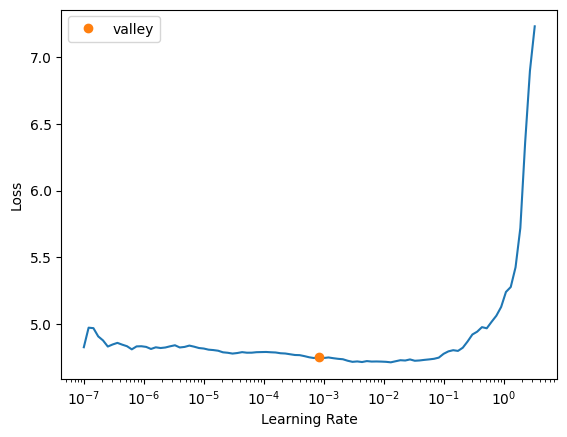

In [11]:
learn.lr_find()

In [12]:
learn.fit_flat_cos(10, 1e-3)

It needs ImageNet pretraining of the encoder. It is documented on the paper.
> First, we attempted to train TimeSformer on video datasets
directly, without ImageNet pretraining. For these exper-
iments, we followed the training-from-scratch protocol
of Touvron et al. (2020) and we also evaluated some vari-
ants of it. However, the model failed to learn meaningful
features.

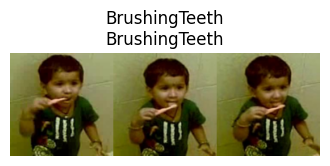

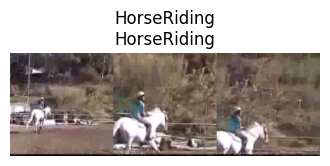

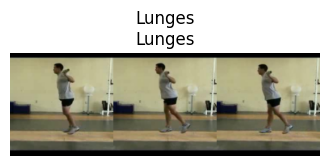

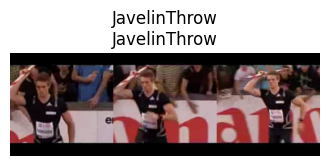

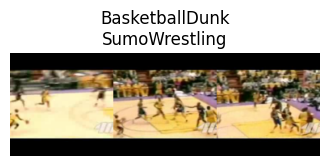

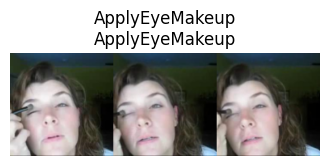

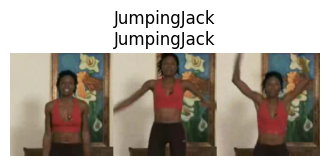

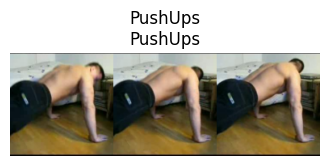

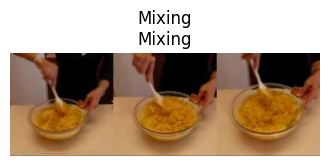

In [13]:
learn.show_results()

In [14]:
learn.validate()

(#3) [0.5281118750572205,0.8671171069145203,0.9590840935707092]

## STAM

In [15]:
model = STAM(
    dim = 256,
    image_size = 128,     # size of image
    patch_size = 16,      # patch size
    num_frames = 20,       # number of image frames, selected out of video
    space_depth = 6,     # depth of vision transformer
    space_heads = 8,      # heads of vision transformer
    space_mlp_dim = 512, # feedforward hidden dimension of vision transformer
    time_depth = 6,       # depth of time transformer (in paper, it was shallower, 6)
    time_heads = 4,       # heads of time transformer
    time_mlp_dim = 512,  # feedforward hidden dimension of time transformer
    num_classes = dls.c,    # number of output classes
    space_dim_head = 64,  # space transformer head dimension
    time_dim_head = 64,   # time transformer head dimension
    dropout = 0.1,         # dropout
    emb_dropout = 0.1      # embedding dropout
)

In [18]:
learn = Learner(dls, model, metrics=[accuracy, top_k_accuracy], wd=0.1, opt_func=ranger).to_fp16()

In [19]:
learn.lr_find()

RuntimeError: The size of tensor a (11) must match the size of tensor b (20) at non-singleton dimension 1

In [13]:
learn.fit_flat_cos(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.170582,4.159558,0.067192,0.240240,01:13
1,3.840004,3.780625,0.124249,0.332958,01:14
2,3.423663,3.461751,0.173799,0.430931,01:14
3,3.182003,3.159376,0.231982,0.516141,01:15
4,2.927474,2.946830,0.256006,0.570571,01:14
5,2.691590,2.756973,0.314565,0.615991,01:14
6,2.514208,2.534678,0.367492,0.670045,01:14
7,2.319239,2.332983,0.412538,0.728604,01:14
8,2.085423,2.129540,0.464339,0.772523,01:24
9,1.881707,2.051139,0.481231,0.778153,01:13


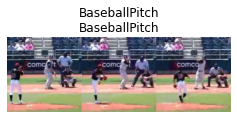

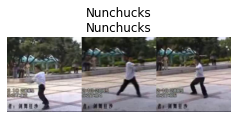

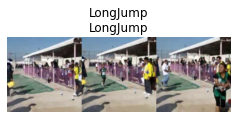

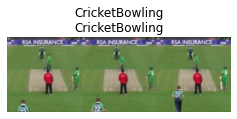

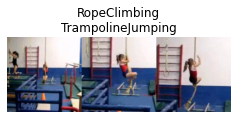

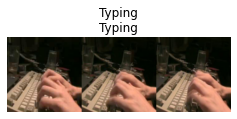

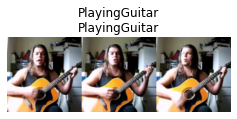

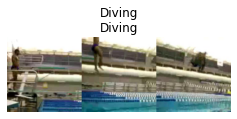

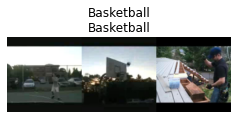

In [12]:
learn.show_results()